In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import re
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"Gensim version: {__import__('gensim').__version__}")

Libraries imported successfully!
Gensim version: 4.4.0


In [5]:
# Load the data
df = pd.read_csv('potential-talents - Aspiring human resources - seeking human resources.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)

Dataset shape: (104, 5)

First few rows:


,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources prof...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
5,6,Aspiring Human Resources Specialist,Greater New York City Area,1,NaN
6,7,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
8,9,Student at Humber College and Aspiring Human Resources Generalist,Kanada,61,NaN
9,10,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,NaN


## Word2Vec Ranking System

We'll create a ranking system that uses Word2Vec embeddings to represent job titles and compute similarity scores.

In [6]:
class Word2VecRankingSystem:
    """
    A ranking system using Word2Vec embeddings for semantic matching.
    """
    
    def __init__(self, keywords, use_connections=True, vector_size=100, window=5, min_count=1):
        """
        Initialize the Word2Vec ranking system.
        
        Parameters:
        -----------
        keywords : str or list
            Target role keywords to match against
        use_connections : bool
            Whether to factor in number of connections
        vector_size : int
            Dimensionality of word vectors
        window : int
            Maximum distance between current and predicted word
        min_count : int
            Ignores words with total frequency lower than this
        """
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        self.starred_candidates = []
        self.ranking_history = []
        
    def preprocess_text(self, text):
        """Clean and preprocess text data."""
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def tokenize(self, text):
        """Tokenize text into words."""
        return simple_preprocess(self.preprocess_text(text), deacc=True)
    
    def normalize_connections(self, connections_series):
        """Normalize connection counts to 0-1 scale."""
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def get_document_vector(self, tokens):
        """
        Get document vector by averaging word vectors.
        """
        vectors = []
        for token in tokens:
            if token in self.model.wv:
                vectors.append(self.model.wv[token])
        
        if len(vectors) == 0:
            return np.zeros(self.vector_size)
        
        return np.mean(vectors, axis=0)
    
    def train_word2vec(self, df):
        """Train Word2Vec model on all job titles."""
        # Tokenize all job titles
        tokenized_titles = df['job_title'].apply(self.tokenize).tolist()
        
        # Add keywords to training corpus
        tokenized_keywords = [self.tokenize(self.keywords)]
        all_documents = tokenized_keywords + tokenized_titles
        
        # Train Word2Vec model
        self.model = Word2Vec(
            sentences=all_documents,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=4,
            epochs=100,
            sg=1  # Use skip-gram model
        )
        
        print(f"Word2Vec model trained with {len(self.model.wv)} unique words")
        
    def calculate_initial_fit(self, df):
        """Calculate initial fitness scores using Word2Vec embeddings."""
        # Train Word2Vec model
        self.train_word2vec(df)
        
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Calculate cosine similarity
        similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        # Factor in connections if enabled
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def calculate_fit_with_feedback(self, df, starred_indices):
        """Recalculate fitness incorporating starred candidates."""
        # Get keyword vector
        keyword_tokens = self.tokenize(self.keywords)
        keyword_vector = self.get_document_vector(keyword_tokens).reshape(1, -1)
        
        # Get vectors for all job titles
        job_vectors = []
        for title in df['job_title']:
            tokens = self.tokenize(title)
            vector = self.get_document_vector(tokens)
            job_vectors.append(vector)
        
        job_vectors = np.array(job_vectors)
        
        # Base similarity to keywords
        keyword_similarities = cosine_similarity(keyword_vector, job_vectors).flatten()
        
        if len(starred_indices) > 0:
            # Calculate similarity to starred candidates
            starred_vectors = job_vectors[starred_indices]
            starred_similarities = cosine_similarity(job_vectors, starred_vectors)
            max_starred_sim = starred_similarities.max(axis=1)
            
            # Combine scores
            weight_starred = min(0.6, 0.3 + (len(starred_indices) * 0.05))
            weight_keyword = 1 - weight_starred
            
            combined_scores = (weight_keyword * keyword_similarities + 
                             weight_starred * max_starred_sim)
        else:
            combined_scores = keyword_similarities
        
        # Factor in connections
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.85 * combined_scores + 0.15 * connection_scores
        else:
            final_scores = combined_scores
        
        return final_scores
    
    def rank_candidates(self, df, starred_indices=None):
        """Rank candidates and return sorted dataframe."""
        df_copy = df.copy()
        
        if starred_indices is None or len(starred_indices) == 0:
            fit_scores = self.calculate_initial_fit(df_copy)
        else:
            fit_scores = self.calculate_fit_with_feedback(df_copy, starred_indices)
        
        df_copy['fit_word2vec'] = fit_scores
        df_copy = df_copy.sort_values('fit_word2vec', ascending=False).reset_index(drop=True)
        df_copy['rank'] = range(1, len(df_copy) + 1)
        
        self.ranking_history.append(df_copy[['id', 'rank', 'fit_word2vec']].copy())
        
        return df_copy
    
    def star_candidate(self, df, candidate_rank):
        """Star a candidate and re-rank."""
        candidate_idx = df.index[df['rank'] == candidate_rank].tolist()[0]
        
        if candidate_idx not in self.starred_candidates:
            self.starred_candidates.append(candidate_idx)
            print(f"✭ Starred: {df.loc[candidate_idx, 'job_title']}")
        
        return self.rank_candidates(df, self.starred_candidates)

print("Word2VecRankingSystem class defined successfully!")

Word2VecRankingSystem class defined successfully!


In [7]:
# Initialize Word2Vec ranking system
keywords = "aspiring human resources seeking human resources"
word2vec_system = Word2VecRankingSystem(keywords, use_connections=True, vector_size=100)

print(f"Word2Vec system initialized with keywords: '{keywords}'")

Word2Vec system initialized with keywords: 'aspiring human resources seeking human resources'


In [8]:
# Rank candidates using Word2Vec
ranked_word2vec = word2vec_system.rank_candidates(df)

print("Word2Vec Ranking Complete!")
print(f"\nTop 15 Candidates (Word2Vec):")
print("="*100)
ranked_word2vec[['rank', 'job_title', 'location', 'connection', 'fit_word2vec']].head(15)

Word2Vec model trained with 194 unique words
Word2Vec Ranking Complete!

Top 15 Candidates (Word2Vec):


,rank,job_title,location,connection,fit_word2vec
0,1,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
1,2,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
2,3,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
3,4,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+,0.996310
4,5,"Human Resources, Staffing and Recruiting Professional","Jackson, Mississippi Area",500+,0.990366
5,6,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.988905
6,7,Aspiring Human Resources Management student seeking an internship,"Houston, Texas Area",500+,0.988905
7,8,Human Resources Generalist at Schwan's,Amerika Birleşik Devletleri,500+,0.972111
8,9,Human Resources Generalist at Loparex,"Raleigh-Durham, North Carolina Area",500+,0.970473
9,10,"Human Resources Generalist at ScottMadden, Inc.","Raleigh-Durham, North Carolina Area",500+,0.958965


## Compare with TF-IDF Baseline

In [9]:
# Load TF-IDF baseline for comparison
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFRankingSystem:
    """Baseline TF-IDF system for comparison."""
    
    def __init__(self, keywords, use_connections=True):
        self.keywords = keywords if isinstance(keywords, str) else ' '.join(keywords)
        self.use_connections = use_connections
        self.vectorizer = TfidfVectorizer(
            stop_words='english',
            ngram_range=(1, 3),
            min_df=1,
            lowercase=True
        )
    
    def preprocess_text(self, text):
        if pd.isna(text):
            return ""
        text = str(text).lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text
    
    def normalize_connections(self, connections_series):
        def parse_connection(conn):
            if pd.isna(conn):
                return 0
            conn_str = str(conn).strip()
            if '500+' in conn_str:
                return 500
            try:
                return int(conn_str)
            except:
                return 0
        
        connections_numeric = connections_series.apply(parse_connection)
        max_conn = connections_numeric.max()
        if max_conn > 0:
            return connections_numeric / max_conn
        return connections_numeric
    
    def calculate_initial_fit(self, df):
        df['processed_title'] = df['job_title'].apply(self.preprocess_text)
        all_texts = [self.keywords] + df['processed_title'].tolist()
        tfidf_matrix = self.vectorizer.fit_transform(all_texts)
        
        keyword_vector = tfidf_matrix[0:1]
        candidate_vectors = tfidf_matrix[1:]
        
        similarities = cosine_similarity(keyword_vector, candidate_vectors).flatten()
        
        if self.use_connections and 'connection' in df.columns:
            connection_scores = self.normalize_connections(df['connection'])
            final_scores = 0.8 * similarities + 0.2 * connection_scores
        else:
            final_scores = similarities
        
        return final_scores
    
    def rank_candidates(self, df):
        df_copy = df.copy()
        fit_scores = self.calculate_initial_fit(df_copy)
        df_copy['fit_tfidf'] = fit_scores
        df_copy = df_copy.sort_values('fit_tfidf', ascending=False).reset_index(drop=True)
        return df_copy

# Create TF-IDF baseline
tfidf_system = TFIDFRankingSystem(keywords, use_connections=True)
ranked_tfidf = tfidf_system.rank_candidates(df)

print("TF-IDF baseline created for comparison")

TF-IDF baseline created for comparison


In [10]:
# Merge results for comparison
comparison_df = ranked_word2vec[['id', 'job_title', 'location', 'connection', 'rank', 'fit_word2vec']].copy()
comparison_df = comparison_df.rename(columns={'rank': 'rank_word2vec'})

tfidf_ranks = ranked_tfidf[['id', 'fit_tfidf']].copy()
tfidf_ranks['rank_tfidf'] = range(1, len(tfidf_ranks) + 1)

comparison_df = comparison_df.merge(tfidf_ranks, on='id', how='left')
comparison_df['rank_difference'] = comparison_df['rank_tfidf'] - comparison_df['rank_word2vec']

print("Top 20 Candidates - Word2Vec vs TF-IDF Comparison:")
print("="*120)
comparison_df[['rank_word2vec', 'rank_tfidf', 'rank_difference', 'job_title', 
               'fit_word2vec', 'fit_tfidf']].head(20)

Top 20 Candidates - Word2Vec vs TF-IDF Comparison:


,rank_word2vec,rank_tfidf,rank_difference,job_title,fit_word2vec,fit_tfidf
0,1,3,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
1,2,4,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
2,3,5,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
3,4,6,2,Seeking Human Resources HRIS and Generalist Positions,0.996310,0.416951
4,5,27,22,"Human Resources, Staffing and Recruiting Professional",0.990366,0.264212
5,6,8,2,Aspiring Human Resources Management student seeking an internship,0.988905,0.352899
6,7,7,0,Aspiring Human Resources Management student seeking an internship,0.988905,0.352899
7,8,21,13,Human Resources Generalist at Schwan's,0.972111,0.287764
8,9,19,10,Human Resources Generalist at Loparex,0.970473,0.287764
9,10,20,10,"Human Resources Generalist at ScottMadden, Inc.",0.958965,0.287764


## Visualization: Word2Vec vs TF-IDF

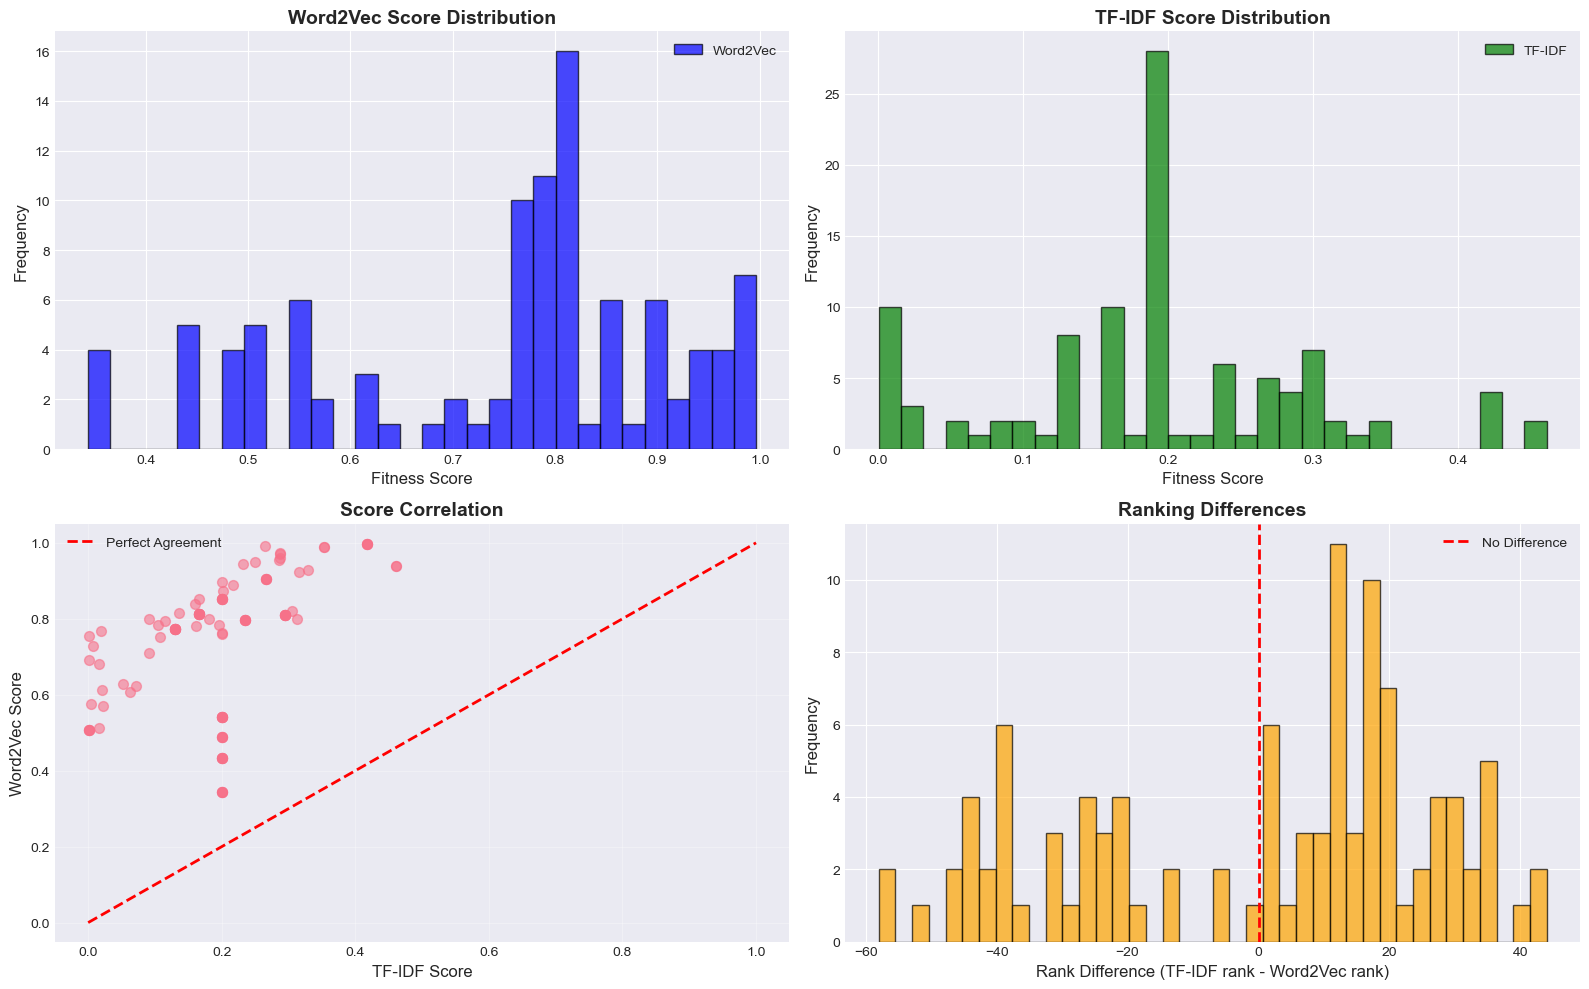


Correlation between Word2Vec and TF-IDF scores: 0.5058


In [11]:
# Score distribution comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Histograms
axes[0, 0].hist(comparison_df['fit_word2vec'], bins=30, alpha=0.7, label='Word2Vec', color='blue', edgecolor='black')
axes[0, 0].set_xlabel('Fitness Score', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Word2Vec Score Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()

axes[0, 1].hist(comparison_df['fit_tfidf'], bins=30, alpha=0.7, label='TF-IDF', color='green', edgecolor='black')
axes[0, 1].set_xlabel('Fitness Score', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('TF-IDF Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].legend()

# Scatter plot: Word2Vec vs TF-IDF scores
axes[1, 0].scatter(comparison_df['fit_tfidf'], comparison_df['fit_word2vec'], alpha=0.6, s=50)
axes[1, 0].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Agreement')
axes[1, 0].set_xlabel('TF-IDF Score', fontsize=12)
axes[1, 0].set_ylabel('Word2Vec Score', fontsize=12)
axes[1, 0].set_title('Score Correlation', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Rank difference distribution
axes[1, 1].hist(comparison_df['rank_difference'], bins=40, alpha=0.7, color='orange', edgecolor='black')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No Difference')
axes[1, 1].set_xlabel('Rank Difference (TF-IDF rank - Word2Vec rank)', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Ranking Differences', fontsize=14, fontweight='bold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Calculate correlation
correlation = comparison_df['fit_word2vec'].corr(comparison_df['fit_tfidf'])
print(f"\nCorrelation between Word2Vec and TF-IDF scores: {correlation:.4f}")

In [12]:
# Statistical comparison
print("Statistical Comparison:")
print("="*80)
print(f"\nWord2Vec Scores:")
print(f"  Mean: {comparison_df['fit_word2vec'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_word2vec'].std():.4f}")
print(f"  Min:  {comparison_df['fit_word2vec'].min():.4f}")
print(f"  Max:  {comparison_df['fit_word2vec'].max():.4f}")

print(f"\nTF-IDF Scores:")
print(f"  Mean: {comparison_df['fit_tfidf'].mean():.4f}")
print(f"  Std:  {comparison_df['fit_tfidf'].std():.4f}")
print(f"  Min:  {comparison_df['fit_tfidf'].min():.4f}")
print(f"  Max:  {comparison_df['fit_tfidf'].max():.4f}")

print(f"\nRank Differences:")
print(f"  Mean Absolute Difference: {comparison_df['rank_difference'].abs().mean():.2f}")
print(f"  Max Rank Change: {comparison_df['rank_difference'].abs().max():.0f}")
print(f"  Candidates with >10 rank difference: {(comparison_df['rank_difference'].abs() > 10).sum()}")

Statistical Comparison:

Word2Vec Scores:
  Mean: 0.7433
  Std:  0.1774
  Min:  0.3440
  Max:  0.9963

TF-IDF Scores:
  Mean: 0.1938
  Std:  0.1066
  Min:  0.0008
  Max:  0.4610

Rank Differences:
  Mean Absolute Difference: 23.50
  Max Rank Change: 58
  Candidates with >10 rank difference: 88


In [13]:
# Show candidates that differ the most in ranking
print("\nCandidates Ranked Much Higher by Word2Vec (vs TF-IDF):")
print("="*120)
top_word2vec = comparison_df.nsmallest(10, 'rank_difference')
print(top_word2vec[['rank_word2vec', 'rank_tfidf', 'rank_difference', 'job_title', 
                    'fit_word2vec', 'fit_tfidf']].to_string(index=False))

print("\n\nCandidates Ranked Much Higher by TF-IDF (vs Word2Vec):")
print("="*120)
top_tfidf = comparison_df.nlargest(10, 'rank_difference')
print(top_tfidf[['rank_word2vec', 'rank_tfidf', 'rank_difference', 'job_title', 
                 'fit_word2vec', 'fit_tfidf']].to_string(index=False))


Candidates Ranked Much Higher by Word2Vec (vs TF-IDF):
 rank_word2vec  rank_tfidf  rank_difference                                                                                                   job_title  fit_word2vec  fit_tfidf
            95          37              -58                                                             Advisory Board Member at Celal Bayar University      0.489138        0.2
            96          39              -57                                                   Native English Teacher at EPIK (English Program in Korea)      0.433631        0.2
           102          50              -52 SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR      0.343953        0.2
            93          46              -47                                                             Advisory Board Member at Celal Bayar University      0.489138        0.2
            98          52              -46                

## Key Insights

### Word2Vec Strengths:
1. **Semantic Understanding**: Better at capturing meaning and related concepts
2. **Synonym Recognition**: Can identify similar roles with different terminology
3. **Context Awareness**: Learns from word co-occurrence patterns

### Word2Vec Limitations:
1. **Small Dataset**: Performance limited by small corpus (needs larger dataset for better word embeddings)
2. **Averaging Effect**: Document vectors created by averaging may lose important nuances
3. **Out-of-Vocabulary**: Cannot handle words not seen during training

### Comparison with TF-IDF:
- **Score Correlation**: Shows how similarly both methods rank candidates
- **Rank Differences**: Highlights cases where semantic understanding changes rankings
- **Use Case**: Word2Vec better for fuzzy matching; TF-IDF better for exact term matching

In [14]:
# Save comparison results
comparison_df.to_csv('word2vec_vs_tfidf_comparison.csv', index=False)
print("Comparison results saved to 'word2vec_vs_tfidf_comparison.csv'")

Comparison results saved to 'word2vec_vs_tfidf_comparison.csv'
